In [1]:
from WealthIncomeMPModel_case import WealthIncomeModelClass_CaseStudy
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update({
    "axes.grid": True,
    "grid.color": "black",
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "font.size": 14                 
})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from EconDLSolvers import choose_gpu
import torch, gc
import os
import numpy as np
import pandas as pd
# Hyperparameters
device = choose_gpu()
model_DL = {}
torch.cuda.empty_cache()

# 1. Initialize both models 
model_DL[r'Baseline'] = WealthIncomeModelClass_CaseStudy(
    device=device,
    load='DeepSimulate_hetero_beta.pkl'
)

model_DL[r'Experiment'] = WealthIncomeModelClass_CaseStudy(
    device=device,
    load='DeepSimulate_hetero_beta.pkl'
)


# 2. modify par manually
model_DL[r'Baseline'].par.R_shock = 0
model_DL[r'Baseline'].par.experiment = None

model_DL[r'Experiment'].par.experiment = "R1pp"
model_DL[r'Experiment'].par.R_shock = -0.01
#model_DL[r'Experiment'].par.shock_periods = [(25, 30)] #, (40,45)]



GPU 0: 79.19GB free
Best GPU: 0


In [ ]:
def simulate_model(model):
    """ Simulate full lifecycle for one model. """
    
    par = model.par
    sim = model.sim

    # 1. Draw initial states
    initial_states = model.draw_initial_states(sim.N)

    # 2. Draw shocks
    shocks = model.draw_shocks(sim.N)

    # 3. Move shocks to same device
    device = sim.states.device
    shocks = shocks.to(device)

    # 4. Set into simulation
    sim.states[0] = initial_states
    sim.shocks = shocks

    # 5. Simulation loop
    for t in range(par.T-1):
        states_t = sim.states[t,:,:]
        shocks_t = sim.shocks[t]

        actions_t = model.eval_policy(model.policy_NN, states_t.unsqueeze(0))
        actions_t = actions_t.squeeze(0)

        outcomes_t = model.outcomes(states_t, actions_t, t0=t, t=t)
        reward_t = model.reward(states_t, actions_t, outcomes_t, t0=t)

        states_pd_t = model.state_trans_pd(states_t, actions_t, outcomes_t, t0=t)
        states_tp1 = model.state_trans(states_pd_t, shocks_t, t=t)

        sim.states[t+1] = states_tp1
        sim.outcomes[t] = outcomes_t
        sim.actions[t] = actions_t
        sim.reward[t] = reward_t



In [ ]:
# Loop over all models in model_DL
for model_name, model in model_DL.items():
    print(f"Simulating {model_name}...")
    simulate_model(model)

In [ ]:
### PLOT FIGURES OUTCOMES

# --------------------------------------------------
# 1.  CREATE CANVAS   (2 rows × 3 columns = 6 slots)
# --------------------------------------------------
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(16, 6),
    constrained_layout=True          # auto-spacer, so no tight_layout later
)
axes = axes.flatten()

titles = [
    'Consumption',        # 0
    'Labor Supply',       # 1
    'Resources',         # 2
    'Liquid Asset',       # 3
    'Illiquid Asset',     # 4
    'New Debt'            # 5
]

# Map each variable index to a subplot index
var_to_ax = {
    0: 0,  # Consumption
    1: 1,  # Labor Supply
    2: 2,  # Ressources
    3: 3,  # Liquid Asset
    4: 4,  # Illiquid Asset
    5: 5,  # New Debt
}


# --------------------------------------------------
# 2.  PLOT THE SERIES
# --------------------------------------------------
for model_key, model_obj in model_DL.items():   # e.g. 'DeepSimulate', 'DeepVPD'
    outcomes = model_obj.sim.outcomes.detach().cpu().numpy()

    for var_idx, ax_idx in var_to_ax.items():
        data = outcomes[:, :, var_idx]

        mean = data.mean(axis=1)
        std  = data.std(axis=1)
        p5, p95 = np.percentile(data, [5, 95], axis=1)

        age = np.arange(data.shape[0]) + 18     # ages 18+

        ax = axes[ax_idx]
        ax.plot(age, mean, lw=2, label=model_key)             # mean line
        ax.fill_between(age, mean-2*std, mean+2*std, alpha=0.2)  # ±2σ band
        ax.plot(age, p5,  ls='--', alpha=0.5)                  # 5th perc.
        ax.plot(age, p95, ls='--', alpha=0.5)                  # 95th perc.
        ax.axvline(67, ls=':', color='k', alpha=0.7)           # retirement

# --------------------------------------------------
# 3.  AESTHETICS
# --------------------------------------------------
# titles
for idx, title in enumerate(titles):
    axes[idx].set_title(title)

# y-axis format
for ax in axes:
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# --------------------------------------------------
# 4.  SINGLE, DEDUPLICATED LEGEND
# --------------------------------------------------
handles, labels = axes[0].get_legend_handles_labels()
uniq = {lab: h for h, lab in zip(handles, labels)}          # keep one of each

fig.legend(uniq.values(), uniq.keys(),
           loc='upper center',
           ncol=2,
           bbox_to_anchor=(0.5, -0.08))     # slight negative y → just below panels

# --------------------------------------------------
# 5.  SAVE / SHOW
# --------------------------------------------------
fig.savefig("Outcomes_Baseline_Experiment_SOFT.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- 1) Define shares to plot ---
# 1: illiquid, 2: liquid, 3: debt; plus computed consumption
plot_order = [
    (1, 'Illiquid Share'),
    (2, 'Liquid Share'),
    (3, 'Debt Share'),
    ('cons', 'Consumption Share')
]

age_start = 18
ret_age   = 67

# --- 2) Prepare 2×2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# --- 3) Loop over models and panels ---
for model_key in model_DL:
    actions = model_DL[model_key].sim.actions.detach().cpu().numpy()
    T       = actions.shape[0]
    x       = np.arange(age_start, age_start + T)

    # compute consumption share
    ill  = actions[:, :, 1]
    liq  = actions[:, :, 2]
    cons = (1 - ill) * (1 - liq)

    for ax, (v_idx, title) in zip(axes, plot_order):
        if v_idx == 'cons':
            data = cons
            xplt = x
        else:
            data = actions[:, :, v_idx]
            if title == 'Debt Share':
                mask = x <= ret_age
                xplt = x[mask]
                data = data[mask, :]
            else:
                xplt = x

        mean    = data.mean(1)
        std     = data.std(1)
        p5, p95 = np.percentile(data, [5, 95], axis=1)

        lower = np.maximum(mean - 2*std, 0)
        upper = np.minimum(mean + 2*std, 1)
        p5    = np.maximum(p5, 0)
        p95   = np.minimum(p95, 1)

        ax.plot(xplt, mean, lw=2, label=model_key)
        ax.fill_between(xplt, lower, upper, alpha=0.2)
        ax.plot(xplt, p5 , ls='--', alpha=0.5)
        ax.plot(xplt, p95, ls='--', alpha=0.5)

        # retirement line on all panels
        ax.axvline(ret_age, color='gray', ls=':', lw=1)

        ax.set_title(title)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        ax.set_ylim(0,1)

# --- 4) Configure x-axis only on bottom row ---
for idx, ax in enumerate(axes):
    if idx >= 2:
        ax.set_xlabel("Age")
    else:
        ax.tick_params(labelbottom=False)

# --- 5) Legend & layout ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', bbox_to_anchor=(0.5, 0.02),
           ncol=len(labels), frameon=False)

fig.tight_layout(rect=[0, 0.05, 1, 0.95])

fig.savefig('Actions_Baseline_Experiment_SOFT.png', dpi=300)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

# --- 1) Which state‐indices to show ---
core_vars = {
    1: 'Wage',
    2: 'Cash-on-Hand',
    3: 'Inflation',
    4: 'Nominal Interest Rate',
    5: 'Return on Illiquid Assets',
    6: 'Debt'
}

age_start = 18
ret_age   = 67
n_vars    = len(core_vars)
n_cols    = 3
n_rows    = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5*n_cols, 4*n_rows),
                         sharex=True)
axes = axes.flatten()

for model_key in model_DL:
    states = model_DL[model_key].sim.states.detach().cpu().numpy()
    T      = states.shape[0]
    x_full = np.arange(age_start, age_start + T)

    for pos, (var_idx, title) in enumerate(core_vars.items()):
        ax   = axes[pos]
        data = states[:, :, var_idx]     # (T, n_sims)

        # For Wage only: cut off beyond retirement
        if title == 'Wage':
            mask = x_full <= ret_age
            x = x_full[mask]
            data = data[mask, :]
        else:
            x = x_full

        mean    = data.mean(1)
        std     = data.std(1)
        p5, p95 = np.percentile(data, [5,95], axis=1)

        ax.plot(x, mean, lw=2, label=model_key)
        ax.fill_between(x, mean-2*std, mean+2*std, alpha=0.25)
        ax.plot(x, p5 , ls='--', alpha=0.5)
        ax.plot(x, p95, ls='--', alpha=0.5)

        # make retirement line more visible: thicker, darker
        ax.axvline(ret_age, color='black', ls='--', lw=2)

        ax.set_title(title)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# hide any unused panels
for extra_ax in axes[n_vars:]:
    extra_ax.axis('off')

# show x‐ticklabels only on bottom row
for pos, ax in enumerate(axes[:n_vars]):
    if pos // n_cols == n_rows - 1:
        ax.set_xlabel("Age")
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)

# shared legend below
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', bbox_to_anchor=(0.5, 0.02),
           ncol=len(labels), frameon=False)

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig("States_Baseline_Experiment_SOFT.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:


# --- 1) simulate_model helper (mutates model.sim and returns it) ---
def simulate_model(model):
    par = model.par
    sim = model.sim

    # initial conditions
    sim.states[0] = model.draw_initial_states(sim.N)
    sim.shocks    = model.draw_shocks(sim.N).to(sim.states.device)

    # lifecycle
    for t in range(par.T - 1):
        s_t   = sim.states[t]
        eps_t = sim.shocks[t]

        a_t        = model.eval_policy(model.policy_NN, s_t.unsqueeze(0)).squeeze(0)
        out_t      = model.outcomes(s_t, a_t, t0=t, t=t)
        sim.reward[t] = model.reward(s_t, a_t, out_t, t0=t)

        pd_t           = model.state_trans_pd(s_t, a_t, out_t, t0=t)
        sim.states[t+1] = model.state_trans(pd_t, eps_t, t=t)

        sim.outcomes[t] = out_t
        sim.actions[t]  = a_t

    return sim

# --- 2) Net-wealth helper ---
def compute_net_wealth(states, outcomes):
    ill  = states[..., 0]
    liq  = outcomes[..., 3]
    debt = states[..., 6]
    nd   = outcomes[..., 5]
    return ill + liq - debt - nd

# --- 3) Age-bin definitions ---
age_start  = 18
age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

# --- 4) Loop over bins, collect pooled net-wealth lists ---
bins_hi = []  # Baseline
bins_lo = []  # Experiment

for (a_lo, a_hi) in age_bins:
    # map age-range to t-range
    t_lo = a_lo - age_start
    t_hi = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    periods = list(range(t_lo, t_hi + 1))

    # Baseline run (no shock)
    model_DL['Baseline'].par.shock_periods   = []
    sim_b = simulate_model(model_DL['Baseline'])
    sh_b, oh_b = sim_b.states.detach().cpu().numpy(), sim_b.outcomes.detach().cpu().numpy()
    nw_b = compute_net_wealth(sh_b, oh_b)

    # Experiment run (shock full bin)
    model_DL['Experiment'].par.shock_periods = periods
    sim_e = simulate_model(model_DL['Experiment'])
    sh_e, oh_e = sim_e.states.detach().cpu().numpy(), sim_e.outcomes.detach().cpu().numpy()
    nw_e = compute_net_wealth(sh_e, oh_e)

    # pool all ages in bin: flatten net-wealth over those periods and all sims
    pooled_b = nw_b[periods, :].ravel()
    pooled_e = nw_e[periods, :].ravel()
    bins_hi.append(pooled_b)
    bins_lo.append(pooled_e)

# --- 5) Plot with the desired styling ---
labels = age_labels
x      = np.arange(len(labels))
pos_hi = x - 0.15
pos_lo = x + 0.15
clr_hi = "#ff9999"
clr_lo = "#66b3ff"

common_kw = dict(
    notch=True,
    showfliers=False,
    whis=1.5,
    medianprops=dict(color="black", linewidth=1.2),
)

fig, ax = plt.subplots(figsize=(10, 6))

bp_hi = ax.boxplot(
    bins_hi, positions=pos_hi, widths=0.28, patch_artist=True,
    boxprops=dict(facecolor=clr_hi, alpha=0.6, linewidth=1),
    **common_kw
)
bp_lo = ax.boxplot(
    bins_lo, positions=pos_lo, widths=0.28, patch_artist=True,
    boxprops=dict(facecolor=clr_lo, alpha=0.6, linewidth=1),
    **common_kw
)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Net-wealth level")
ax.legend(
    [bp_hi["boxes"][0], bp_lo["boxes"][0]],
    ["Baseline", "Experiment"],
    loc="upper left",
    frameon=False
)

# annotate one box, e.g. "50–64"
i = labels.index("50–64")
data = bins_hi[i]
q1, med, q3 = np.percentile(data, [25, 50, 75])
iqr = q3 - q1
whisk_low  = np.min(data[data >= q1 - 1.5 * iqr])
whisk_high = np.max(data[data <= q3 + 1.5 * iqr])
mean_val   = np.mean(data)

stat_text = (
    "Age 50–64, Baseline\n"
    f"Min    = {whisk_low:.0f}\n"
    f"Median = {med:.0f}\n"
    f"Mean   = {mean_val:.0f}\n"
    f"Max    = {whisk_high:.0f}"
)

ax.annotate(
    stat_text,
    xy=(pos_hi[i], med),
    xytext=(0.02, 0.75),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1),
    va="center", ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.4",
              facecolor="white", edgecolor="gray", linewidth=1)
)

plt.tight_layout()
plt.show()
fig.savefig("boxplot_netwealth_base_experiment_SOFT.png", dpi = 300)

In [ ]:

#misc
def simulate_model(model):
    par = model.par
    sim = model.sim

    # initial conditions
    sim.states[0] = model.draw_initial_states(sim.N)
    sim.shocks    = model.draw_shocks(sim.N).to(sim.states.device)

    # lifecycle
    for t in range(par.T - 1):
        s_t   = sim.states[t]
        eps_t = sim.shocks[t]

        a_t        = model.eval_policy(model.policy_NN, s_t.unsqueeze(0)).squeeze(0)
        out_t      = model.outcomes(s_t, a_t, t0=t, t=t)
        sim.reward[t] = model.reward(s_t, a_t, out_t, t0=t)

        pd_t           = model.state_trans_pd(s_t, a_t, out_t, t0=t)
        sim.states[t+1] = model.state_trans(pd_t, eps_t, t=t)

        sim.outcomes[t] = out_t
        sim.actions[t]  = a_t

    return sim
# --- 1) Work‐income helper ---
def compute_work_income(states, outcomes, kappa):
    """
    states:   (T, N, n_states)    where state index 1 is wage
    outcomes: (T, N, n_outcomes)   where outcome index 2 is labor hours share
    kappa:    (T,) array of labor efficiency
    Returns:  (T, N) work-related income = kappa[t] * wage * hours_share
    """
    wages      = states[..., 1]      # wage
    hours      = outcomes[..., 2]    # labor hours share
    # broadcast kappa across agents
    return kappa[:, None] * wages * hours

# --- 3) Age‐bin definitions ---
age_start  = 18
age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

# --- 4) Loop over bins, collect pooled work‐income lists ---
bins_hi = []  # Baseline
bins_lo = []  # Experiment

for (a_lo, a_hi) in age_bins:
    # map age‐range to t‐range
    t_lo = a_lo - age_start
    t_hi = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    periods = list(range(t_lo, t_hi + 1))

    # --- Baseline run (no shock) ---
    model_DL['Baseline'].par.shock_periods   = []
    sim_b = simulate_model(model_DL['Baseline'])
    sh_b, oh_b = sim_b.states.detach().cpu().numpy(), sim_b.outcomes.detach().cpu().numpy()
    kappa_b    = model_DL['Baseline'].par.kappa.detach().cpu().numpy()
    wi_b       = compute_work_income(sh_b, oh_b, kappa_b)

    # --- Experiment run (shock full bin) ---
    model_DL['Experiment'].par.shock_periods = periods
    sim_e = simulate_model(model_DL['Experiment'])
    sh_e, oh_e = sim_e.states.detach().cpu().numpy(), sim_e.outcomes.detach().cpu().numpy()
    kappa_e    = model_DL['Experiment'].par.kappa.detach().cpu().numpy()
    wi_e       = compute_work_income(sh_e, oh_e, kappa_e)

    # pool all ages in bin: flatten work‐income over those periods and all sims
    pooled_b = wi_b[periods, :].ravel()
    pooled_e = wi_e[periods, :].ravel()
    bins_hi.append(pooled_b)
    bins_lo.append(pooled_e)

# --- 5) Plot with the desired styling ---
labels = age_labels
x      = np.arange(len(labels))
pos_hi = x - 0.15
pos_lo = x + 0.15
clr_hi = "#ff9999"
clr_lo = "#66b3ff"

common_kw = dict(
    notch=True,
    showfliers=False,
    whis=1.5,
    medianprops=dict(color="black", linewidth=1.2),
)

fig, ax = plt.subplots(figsize=(10, 6))

bp_hi = ax.boxplot(
    bins_hi, positions=pos_hi, widths=0.28, patch_artist=True,
    boxprops=dict(facecolor=clr_hi, alpha=0.6, linewidth=1),
    **common_kw
)
bp_lo = ax.boxplot(
    bins_lo, positions=pos_lo, widths=0.28, patch_artist=True,
    boxprops=dict(facecolor=clr_lo, alpha=0.6, linewidth=1),
    **common_kw
)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Work‐related income")
ax.legend(
    [bp_hi["boxes"][0], bp_lo["boxes"][0]],
    ["Baseline", "Experiment"],
    loc="upper left",
    frameon=False
)

# annotate one box, e.g. "50–64"
i = labels.index("50–64")
data = bins_hi[i]
q1, med, q3 = np.percentile(data, [25, 50, 75])
iqr = q3 - q1
whisk_low  = np.min(data[data >= q1 - 1.5 * iqr])
whisk_high = np.max(data[data <= q3 + 1.5 * iqr])
mean_val   = np.mean(data)

stat_text = (
    "Age 50–64, Baseline\n"
    f"Min    = {whisk_low:.0f}\n"
    f"Median = {med:.0f}\n"
    f"Mean   = {mean_val:.0f}\n"
    f"Max    = {whisk_high:.0f}"
)

ax.annotate(
    stat_text,
    xy=(pos_hi[i], med),
    xytext=(0.02, 0.75),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1),
    va="center", ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.4",
              facecolor="white", edgecolor="gray", linewidth=1)
)

plt.tight_layout()
plt.show()
plt.savefig("boxplot_work_income_baseline_experiment_SOFT.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) simulate_model helper (mutates model.sim and returns it) ---
def simulate_model(model):
    par = model.par
    sim = model.sim

    # initial conditions
    sim.states[0] = model.draw_initial_states(sim.N)
    sim.shocks    = model.draw_shocks(sim.N).to(sim.states.device)

    # lifecycle
    for t in range(par.T - 1):
        s_t   = sim.states[t]
        eps_t = sim.shocks[t]

        a_t          = model.eval_policy(model.policy_NN, s_t.unsqueeze(0)).squeeze(0)
        out_t        = model.outcomes(s_t, a_t, t0=t, t=t)
        sim.reward[t] = model.reward(s_t, a_t, out_t, t0=t)

        pd_t           = model.state_trans_pd(s_t, a_t, out_t, t0=t)
        sim.states[t+1] = model.state_trans(pd_t, eps_t, t=t)

        sim.outcomes[t] = out_t
        sim.actions[t]  = a_t

    return sim

# --- 2) Investment‐income helper ---
def compute_invest_income(states, outcomes):
    """
    states:   (T, N, n_states)
      idx0 = illiquid assets carried over
      idx5 = return on illiquid
      idx4 = return on liquid
    outcomes: (T, N, n_outcomes)
      idx4 = new illiquid assets
      idx3 = new liquid assets
    """
    ill_prev = states[..., 0]
    rtn_ill  = states[..., 5]
    rtn_liq  = states[..., 4]
    ill_new  = outcomes[..., 4]
    liq_new  = outcomes[..., 3]
    return (ill_prev + ill_new) * rtn_ill + liq_new * rtn_liq

# --- 3) Age‐bin definitions ---
age_start  = 18
age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]
age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

# --- 4) Loop over bins, collect pooled investment‐income lists ---
bins_hi = []  # Baseline (Patient β=0.99)
bins_lo = []  # Experiment (Impatient β=0.95)

for (a_lo, a_hi) in age_bins:
    t_lo = a_lo - age_start
    t_hi = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    periods = list(range(t_lo, t_hi + 1))

    # Baseline run
    model_DL['Baseline'].par.shock_periods = periods
    sim_b = simulate_model(model_DL['Baseline'])
    sh_b, oh_b = sim_b.states.detach().cpu().numpy(), sim_b.outcomes.detach().cpu().numpy()
    inv_b      = compute_invest_income(sh_b, oh_b)

    # Experiment run
    model_DL['Experiment'].par.shock_periods = periods
    sim_e = simulate_model(model_DL['Experiment'])
    sh_e, oh_e = sim_e.states.detach().cpu().numpy(), sim_e.outcomes.detach().cpu().numpy()
    inv_e      = compute_invest_income(sh_e, oh_e)

    # pool across the bin
    bins_hi.append(inv_b[periods, :].ravel())
    bins_lo.append(inv_e[periods, :].ravel())

# --- 5) Plot with consistent box‐plot style ---
labels = age_labels
x      = np.arange(len(labels))
pos_hi = x - 0.15
pos_lo = x + 0.15
clr_hi = "#ff9999"
clr_lo = "#66b3ff"

common_kw = dict(
    notch=True,
    showfliers=False,
    whis=1.5,
    medianprops=dict(color="black", linewidth=1.2),
)

fig, ax = plt.subplots(figsize=(10, 6))

bp_hi = ax.boxplot(
    bins_hi, positions=pos_hi, widths=0.28, patch_artist=True,
    boxprops=dict(facecolor=clr_hi, alpha=0.6, linewidth=1),
    **common_kw
)
bp_lo = ax.boxplot(
    bins_lo, positions=pos_lo, widths=0.28, patch_artist=True,
    boxprops=dict(facecolor=clr_lo, alpha=0.6, linewidth=1),
    **common_kw
)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Investment income")
ax.legend(
    [bp_hi["boxes"][0], bp_lo["boxes"][0]],
    ["Baseline", "Experiment"],
    loc="upper left",
    frameon=False
)

# Annotate stats for "50–64", Baseline
i = labels.index("50–64")
data = bins_hi[i]
q1, med, q3 = np.percentile(data, [25, 50, 75])
iqr = q3 - q1
whisk_low  = np.min(data[data >= q1 - 1.5 * iqr])
whisk_high = np.max(data[data <= q3 + 1.5 * iqr])
mean_val   = data.mean()

stat_text = (
    "Age 50–64, Baseline\n"
    f"Min    = {whisk_low:.0f}\n"
    f"Median = {med:.0f}\n"
    f"Mean   = {mean_val:.0f}\n"
    f"Max    = {whisk_high:.0f}"
)

ax.annotate(
    stat_text,
    xy=(pos_hi[i], med),
    xytext=(0.05, 0.75),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1, color="gray"),
    va="center", ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.4",
              facecolor="white", edgecolor="gray", linewidth=1)
)

plt.tight_layout()
plt.show()
fig.savefig("boxplot_investment_income_SOFT.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) simulate_model helper (mutates model.sim and returns it) ---
def simulate_model(model):
    par = model.par
    sim = model.sim

    # initial conditions
    sim.states[0] = model.draw_initial_states(sim.N)
    sim.shocks    = model.draw_shocks(sim.N).to(sim.states.device)

    # lifecycle
    for t in range(par.T - 1):
        s_t    = sim.states[t]
        eps_t  = sim.shocks[t]
        a_t    = model.eval_policy(model.policy_NN, s_t.unsqueeze(0)).squeeze(0)
        out_t  = model.outcomes(s_t, a_t, t0=t, t=t)
        sim.reward[t] = model.reward(s_t, a_t, out_t, t0=t)
        pd_t           = model.state_trans_pd(s_t, a_t, out_t, t0=t)
        sim.states[t+1] = model.state_trans(pd_t, eps_t, t=t)
        sim.outcomes[t] = out_t
        sim.actions[t]  = a_t

    return sim

# --- 2) Work‐income helper ---
def compute_work_income(states, outcomes, kappa):
    wages = states[..., 1]
    hours = outcomes[..., 2]
    return kappa[:, None] * wages * hours

# --- 3) Age‐bin definitions ---
age_start  = 18
age_bins   = [(18, 34), (35, 49), (50, 64), (65, 74), (75, 84), (85, 200)]

# --- 4) Loop over bins, collect pooled work‐income lists ---
bins_hi = []  # Baseline
bins_lo = []  # Experiment

for (a_lo, a_hi) in age_bins:
    t_lo = a_lo - age_start
    t_hi = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    periods = list(range(t_lo, t_hi + 1))

    # Baseline run
    model_DL['Baseline'].par.shock_periods = periods
    sim_b = simulate_model(model_DL['Baseline'])
    sh_b = sim_b.states.detach().cpu().numpy()
    oh_b = sim_b.outcomes.detach().cpu().numpy()
    kappa_b = model_DL['Baseline'].par.kappa.detach().cpu().numpy()
    wi_b = compute_work_income(sh_b, oh_b, kappa_b)

    # Experiment run
    model_DL['Experiment'].par.shock_periods = periods
    sim_e = simulate_model(model_DL['Experiment'])
    sh_e = sim_e.states.detach().cpu().numpy()
    oh_e = sim_e.outcomes.detach().cpu().numpy()
    kappa_e = model_DL['Experiment'].par.kappa.detach().cpu().numpy()
    wi_e = compute_work_income(sh_e, oh_e, kappa_e)

    # pool across that bin
    bins_hi.append(wi_b[periods, :].ravel())
    bins_lo.append(wi_e[periods, :].ravel())

# flatten across all bins for the full-population distribution
all_hi = np.concatenate(bins_hi)
all_lo = np.concatenate(bins_lo)

# --- 5) Lorenz curve function ---
def lorenz_curve(x):
    x = np.clip(x, 0, None)
    sorted_x = np.sort(x)
    cumx = np.concatenate(([0], np.cumsum(sorted_x)))
    p = np.linspace(0, 1, len(cumx))
    w = cumx / cumx[-1]
    return p, w

# compute Lorenz coordinates
p_hi, w_hi = lorenz_curve(all_hi)
p_lo, w_lo = lorenz_curve(all_lo)

# find maximum gap
gap_hi = p_hi - w_hi
gap_lo = p_lo - w_lo
i_hi = np.argmax(gap_hi)
i_lo = np.argmax(gap_lo)
pmax_hi, gapmax_hi = p_hi[i_hi], gap_hi[i_hi]
pmax_lo, gapmax_lo = p_lo[i_lo], gap_lo[i_lo]
# --- 6) Plot Lorenz curves ---
fig, ax = plt.subplots(figsize=(8, 6))   # get the Figure and Axes

ax.plot(p_hi, w_hi, lw=2, label="Baseline")
ax.plot(p_lo, w_lo, lw=2, label="Experiment")
ax.plot([0,1], [0,1], "k--", alpha=0.6, label="Line of equality")

# annotate as before…
ax.annotate(
    f"Max gap {gapmax_hi*100:.1f}% at {pmax_hi*100:.1f}%",
    xy=(pmax_hi, w_hi[i_hi]),
    xytext=(0.05, 0.65),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1),
    bbox=dict(facecolor="white", edgecolor="gray", pad=0.3),
)
ax.annotate(
    f"Max gap {gapmax_lo*100:.1f}% at {pmax_lo*100:.1f}%",
    xy=(pmax_lo, w_lo[i_lo]),
    xytext=(0.55, 0.30),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1),
    bbox=dict(facecolor="white", edgecolor="gray", pad=0.3),
)

ax.set_xlabel("Cumulative share of population")
ax.set_ylabel("Cumulative share of employment income")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

fig.tight_layout()
fig.savefig("lorenz_employment_income_baseline_experiment_SOFT.png", dpi=300, bbox_inches="tight")
plt.show()



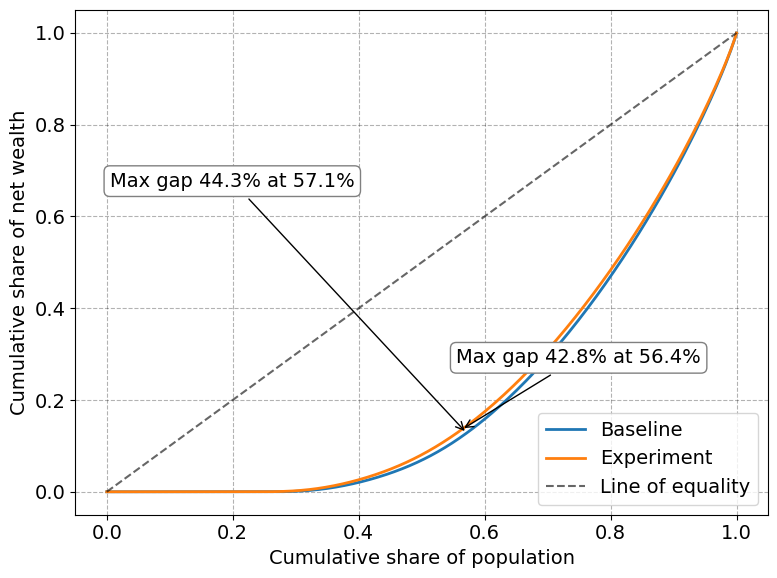

<Figure size 640x480 with 0 Axes>

In [2]:

# --- 1) simulate_model helper (mutates model.sim and returns it) ---
def simulate_model(model):
    par = model.par
    sim = model.sim

    # initial conditions
    sim.states[0] = model.draw_initial_states(sim.N)
    sim.shocks    = model.draw_shocks(sim.N).to(sim.states.device)

    # lifecycle
    for t in range(par.T - 1):
        s_t   = sim.states[t]
        eps_t = sim.shocks[t]

        a_t          = model.eval_policy(model.policy_NN, s_t.unsqueeze(0)).squeeze(0)
        out_t        = model.outcomes(s_t, a_t, t0=t, t=t)
        sim.reward[t] = model.reward(s_t, a_t, out_t, t0=t)

        pd_t           = model.state_trans_pd(s_t, a_t, out_t, t0=t)
        sim.states[t+1] = model.state_trans(pd_t, eps_t, t=t)

        sim.outcomes[t] = out_t
        sim.actions[t]  = a_t

    return sim

# --- 2) net-wealth helper ---
def compute_net_wealth(states, outcomes):
    ill  = states[..., 0]    # illiquid assets
    liq  = outcomes[..., 3]  # liquid assets
    debt = states[..., 6]    # debt
    nd   = outcomes[..., 5]  # new debt
    return ill + liq - debt - nd

# --- 3) Age-bin definitions ---
age_start = 18
age_bins  = [(18, 34), (35, 49), (50, 64),
             (65, 74), (75, 84), (85, 200)]
age_labels = ["18–34", "35–49", "50–64", "65–74", "75–84", "85+"]

# --- 4) Loop bins, collect pooled net-wealth ---
bins_hi = []  # Baseline
bins_lo = []  # Experiment

for (a_lo, a_hi) in age_bins:
    t_lo = a_lo - age_start
    t_hi = min(a_hi - age_start, model_DL['Baseline'].par.T - 1)
    periods = list(range(t_lo, t_hi + 1))

    # baseline run (no shock)
    model_DL['Baseline'].par.shock_periods = periods
    sim_b = simulate_model(model_DL['Baseline'])
    sh_b  = sim_b.states.detach().cpu().numpy()
    oh_b  = sim_b.outcomes.detach().cpu().numpy()
    nw_b  = compute_net_wealth(sh_b, oh_b)

    # experiment run (shock full bin)
    model_DL['Experiment'].par.shock_periods = periods
    sim_e = simulate_model(model_DL['Experiment'])
    sh_e  = sim_e.states.detach().cpu().numpy()
    oh_e  = sim_e.outcomes.detach().cpu().numpy()
    nw_e  = compute_net_wealth(sh_e, oh_e)

    # pool net-wealth across the bin
    bins_hi.append(nw_b[periods, :].ravel())
    bins_lo.append(nw_e[periods, :].ravel())

# flatten to full-population distributions
all_hi = np.concatenate(bins_hi)
all_lo = np.concatenate(bins_lo)

# --- 5) Lorenz curve function ---
def lorenz_curve(x):
    x = np.clip(x, 0, None)
    sorted_x = np.sort(x)
    cumx = np.concatenate(([0], np.cumsum(sorted_x)))
    p = np.linspace(0, 1, len(cumx))
    w = cumx / cumx[-1]
    return p, w

# compute Lorenz coordinates
p_hi, w_hi = lorenz_curve(all_hi)
p_lo, w_lo = lorenz_curve(all_lo)

# find maximum gap positions
gap_hi = p_hi - w_hi
gap_lo = p_lo - w_lo
i_hi = np.argmax(gap_hi)
i_lo = np.argmax(gap_lo)
pmax_hi, gapmax_hi = p_hi[i_hi], gap_hi[i_hi]
pmax_lo, gapmax_lo = p_lo[i_lo], gap_lo[i_lo]

# --- 6) Plot Lorenz curves ---
plt.figure(figsize=(8,6))
plt.plot(p_hi, w_hi, lw=2, label="Baseline")
plt.plot(p_lo, w_lo, lw=2, label="Experiment")
plt.plot([0,1], [0,1], "k--", alpha=0.6, label="Line of equality")

# annotate maximum gaps
plt.annotate(
    f"Max gap {gapmax_hi*100:.1f}% at {pmax_hi*100:.1f}%",
    xy=(pmax_hi, w_hi[i_hi]),
    xytext=(0.05, 0.65),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1),
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
)
plt.annotate(
    f"Max gap {gapmax_lo*100:.1f}% at {pmax_lo*100:.1f}%",
    xy=(pmax_lo, w_lo[i_lo]),
    xytext=(0.55, 0.30),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1),
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
)

plt.xlabel("Cumulative share of population")
plt.ylabel("Cumulative share of net wealth")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("lorenz_net_wealth_baseline_experiment_SOFT.png")
